#Gathering Data



Data is the cornerstone of any machine learning project. For our translation model, we'll use the French-English dataset from TensorFlow's official repository. We'll download and extract the data using TensorFlow's utility functions.

In [ ]:
import tensorflow as tf

# Gathering data using TensorFlow's utility function
text_file = tf.keras.utils.get_file(
    fname='fra-eng.zip',
    origin="http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip",
    extract=True
)


#Data Processing

Once we have the data, the next step is preprocessing. We'll normalize the text, handle special characters, and format it appropriately for training.

In [ ]:
# Importing necessary libraries
import pathlib
import unicodedata
import re

# Defining the path to the text file
text_file = pathlib.Path(text_file).parent / 'fra.txt'

def normalize(line):
    # Normalize unicode characters, strip leading/trailing whitespace, convert to lowercase
    line = unicodedata.normalize("NFKC", line.strip().lower())
    # Handle special characters and add start and end tokens for the target language (French)
    line = re.sub(r"^([^ \w])(?!\s)", r"\1", line)
    line = re.sub(r"(\s[^ \w])(?!\s)", r"\1", line)
    line = re.sub(r"(?!\s)([^ \w])$", r"\1", line)
    line = re.sub(r"(?!\s)([^ \w]\s)", r"\1", line)
    eng, fre = line.split("\t")
    fre = '[start] ' + fre + ' [end]'
    return eng, fre

# Read and normalize the text pairs
with open(text_file) as fp:
    text_pairs = [normalize(line) for line in fp]



#Tokenization and Statistics

Before training, it's crucial to tokenize our text data and understand its characteristics, such as the vocabulary size and maximum sequence lengths.

In [ ]:
# Tokenization and Statistics

# Initialize sets to store unique tokens for English and French
eng_tokens, fre_tokens = set(), set()
# Initialize variables to store maximum sequence lengths
eng_maxlen, fre_maxlen = 0, 0

# Iterate through text pairs to tokenize and compute statistics
for eng, fre in text_pairs:
    eng_token, fre_token = eng.split(), fre.split()
    eng_maxlen = max(eng_maxlen, len(eng_token))
    fre_maxlen = max(fre_maxlen, len(fre_token))
    eng_tokens.update(eng_token)
    fre_tokens.update(fre_token)

# Print statistics
print(f"Total tokens in English: {len(eng_tokens)}")
print(f"Total tokens in French: {len(fre_tokens)}")
print(f"Maximum length of English sequence: {eng_maxlen}")
print(f"Maximum length of French sequence: {fre_maxlen}")



Total tokens in English: 25365
Total tokens in French: 42027
Maximum length of English sequence: 47
Maximum length of French sequence: 56


#Data Serialization

Lastly, we'll serialize our preprocessed data for future use.

In [ ]:
import pickle

# Serialize preprocessed data for future use
with open("text_pairs.pickle", 'wb') as fp:
    pickle.dump(text_pairs, fp)


#Embedding Layer

The first step in building our model is data transformation. We'll preprocess our text data, vectorize it, and create TensorFlow datasets for training and testing.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import pickle
import random

# Load preprocessed text pairs
with open("text_pairs.pickle", 'rb') as fp:
    text_pairs = pickle.load(fp)

# Shuffle the data
random.shuffle(text_pairs)

# Split into train and test sets
n_val = int(0.15 * len(text_pairs))
n_train = len(text_pairs) - 2 * n_val
train_pair = text_pairs[:n_train]
test_pair = text_pairs[n_train: n_train + n_val]

# Vocabulary sizes and sequence length
vocab_en = 10000
vocab_fr = 20000
seq_length = 25

# Initialize TextVectorization layers
eng_vect = TextVectorization(
    max_tokens=vocab_en,
    standardize=None,
    split='whitespace',
    output_mode='int',
    output_sequence_length=seq_length
)

fre_vect = TextVectorization(
    max_tokens=vocab_fr,
    standardize=None,
    split='whitespace',
    output_mode='int',
    output_sequence_length=seq_length + 1  # +1 for start token
)

# Adapt TextVectorization layers to training data
train_eng = [pair[0] for pair in train_pair]
train_fre = [pair[1] for pair in train_pair]

eng_vect.adapt(train_eng)
fre_vect.adapt(train_fre)


# Serialize the vectorization layers and training/test data
with open('vectorize.pickle', 'wb') as fp:
    data = {'train': train_pair,
            'test': test_pair,
            'eng_vect': eng_vect.get_config(),
            'fre_vect': fre_vect.get_config(),
            'eng_weights': eng_vect.get_weights(),
            'fre_weights': fre_vect.get_weights()
            }
    pickle.dump(data, fp)

# Load serialized data
with open("vectorize.pickle", 'rb') as fp:
    data = pickle.load(fp)

# Retrieve train and test pairs
train_pair = data['train']
test_pair = data['test']

# Reconstruct TextVectorization layers
eng_vect = TextVectorization.from_config(data['eng_vect'])
eng_vect.set_weights(data['eng_weights'])
fre_vect = TextVectorization.from_config(data['fre_vect'])
fre_vect.set_weights(data['fre_weights'])

# Define function to format dataset
def format_dataset(eng, fre):
    eng = eng_vect(eng)
    fre = fre_vect(fre)
    source = {'encode_inp': eng,
              'decode_inp': fre[:, :-1]
              }
    target = fre[:, 1:]
    return (source, target)

# Define function to create dataset
def make_dataset(pairs, batchsize=64):
    eng_text, fre_text = zip(*pairs)
    dataset = tf.data.Dataset.from_tensor_slices((list(eng_text), list(fre_text)))
    return dataset.shuffle(2048).batch(batchsize).map(format_dataset).prefetch(16).cache()

# Create TensorFlow datasets for training and testing
train_ds = make_dataset(train_pair)
test_ds = make_dataset(test_pair)


#Positional Embedding

Now, let's implement the positional embedding layer. This layer is essential for helping the model understand the sequential order of tokens in a sentence.

In [ ]:
import numpy as np


# Function to generate positional encoding matrix
def pos_enc_matrix(L, d, n=10000):
    assert d % 2 == 0
    d2 = d // 2

    P = np.zeros((L, d))
    k = np.arange(L).reshape(-1, 1)
    i = np.arange(d2).reshape(1, -1)

    denom = np.power(n, -i / d2)
    args = k * denom

    P[:, ::2] = np.sin(args)
    P[:, 1::2] = np.cos(args)
    return P

# Custom Keras layer for positional embedding
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, seq_length, vocab_size, embed_dim, **kwargs):
      super().__init__(**kwargs)
      self.seq_length = seq_length
      self.vocab_size = vocab_size
      self.embed_dim = embed_dim

      self.token_embeddings = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)
      matrix = pos_enc_matrix(seq_length, embed_dim)

      self.positional_embedding = tf.constant(matrix, dtype='float32')

  def call(self, inputs):
      embedded_tokens = self.token_embeddings(inputs)
      return embedded_tokens + self.positional_embedding

  def compute_mask(self, *args, **kwargs):
      return self.token_embeddings.compute_mask(*args, **kwargs)

  def get_config(self):
      config = super().get_config()
      config.update({
          'seq_length': self.seq_length,
          'vocab_size': self.vocab_size,
          'embed_dim': self.embed_dim
      })

# Usage and Validation
vocab_en = 10000
seq_length = 25

for inputs, targets in train_ds.take(1):
    embed_en = PositionalEmbedding(seq_length, vocab_en, embed_dim=512)
    en_emb = embed_en(inputs['encode_inp'])
    print(en_emb._keras_mask)


FailedPreconditionError: {{function_node __wrapped__IteratorGetNext_output_types_3_device_/job:localhost/replica:0/task:0/device:CPU:0}} Error in user-defined function passed to MapDataset:55 transformation with iterator: Iterator::Root::Prefetch::FiniteTake::MemoryCacheImpl::Prefetch::Map: Table not initialized.
	 [[{{node text_vectorization_7_1/None_Lookup/LookupTableFindV2}}]] [Op:IteratorGetNext] name: 

#Self-Attention Layer
The self-attention mechanism allows our model to weigh the importance of different words within the same input sequence. Let's define a function to create a self-attention layer.


In [ ]:
import tensorflow as tf

def self_attention(input_shape, prefix='att', mask=False, **kwargs):
    # Define inputs
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f"{prefix}_in1")

    # Multi-head attention layer
    attention = tf.keras.layers.MultiHeadAttention(name=f"{prefix}_att1", **kwargs)
    norm = tf.keras.layers.LayerNormalization(name=f'{prefix}_norm1')
    add = tf.keras.layers.Add(name=f'{prefix}_add1')

    # Apply attention mechanism
    attout = attention(query=inputs, value=inputs, key=inputs, use_causal_mask=mask)

    # Apply normalization and residual connection
    output = norm(add([inputs, attout]))

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=output, name=f"{prefix}_att")

    return model


#Cross-Attention Layer

The cross-attention layer enables our model to focus on relevant information from an external context, such as the source sentence in translation tasks. Let's define a function to create a cross-attention layer.

In [ ]:
def cross_attention(input_shape, context_shape, prefix='att', **kwargs):
    # Define inputs
    context = tf.keras.layers.Input(shape=context_shape, dtype='float32', name=f"{prefix}_ctx2")
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f'{prefix}_in2')

    # Multi-head attention layer
    attention = tf.keras.layers.MultiHeadAttention(name=f'{prefix}_att2', **kwargs)
    norm = tf.keras.layers.LayerNormalization(name=f'{prefix}_norm2')
    add = tf.keras.layers.Add(name=f'{prefix}_add2')

    # Apply attention mechanism
    attout = attention(query=inputs, key=context, value=context)

    # Apply normalization and residual connection
    output = norm(add([attout, inputs]))

    # Create the model
    model = tf.keras.Model(inputs=[context, inputs], outputs=output, name=f'{prefix}_crs_at')

    return model


#Feed-Forward Layer

The feed-forward layer consists of two dense layers with a ReLU activation function, followed by dropout and layer normalization. Let's define a function to create the feed-forward layer.

In [ ]:
def feed_forward(input_shape, model_dim, ff_dim, dropout=.1, prefix='ff'):
    # Define inputs
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f'{prefix}_in3')

    # Dense layers
    dense1 = tf.keras.layers.Dense(ff_dim, name=f'{prefix}_ff1', activation='relu')
    dense2 = tf.keras.layers.Dense(model_dim, name=f'{prefix}_ff2')
    drop = tf.keras.layers.Dropout(dropout, name=f'{prefix}_drop')
    add = tf.keras.layers.Add(name=f"{prefix}_add3")

    # Apply feed-forward transformation
    ffout = drop(dense2(dense1(inputs)))

    # Layer normalization and residual connection
    norm = tf.keras.layers.LayerNormalization(name=f'{prefix}_norm3')
    output = norm(add([inputs, ffout]))

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=output, name=f'{prefix}_ff')

    return model


#Encoder Layer

The encoder processes the input sequence and extracts meaningful representations. It consists of self-attention and feed-forward layers.

In [ ]:
import tensorflow as tf

def encoder(input_shape, key_dim, ff_dim, dropout=0.1, prefix='enc', **kwargs):
    # Define a Sequential model for the encoder
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f'{prefix}_in0'), # Input layer
        self_attention(input_shape, prefix=prefix, key_dim=key_dim, mask=False, **kwargs), # Self-attention layer
        feed_forward(input_shape, key_dim, ff_dim, dropout, prefix) # Feed-forward layer
    ])

    return model


#Decoder Layer

The decoder takes the encoder's output and generates the translated sequence. It comprises self-attention, cross-attention, and feed-forward layers.

In [ ]:
def decoder(input_shape, key_dim, ff_dim, dropout=0.1, prefix='dec', **kwargs):
    # Define inputs for decoder
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f'{prefix}_in0')
    context = tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f'{prefix}_ctx0')

    # Self-attention and cross-attention layers
    att_model = self_attention(input_shape, key_dim=key_dim, mask=True, prefix=prefix, **kwargs)
    cross_model = cross_attention(input_shape, input_shape, key_dim=key_dim, prefix=prefix, **kwargs)

    # Feed-forward layer
    ff_model = feed_forward(input_shape, key_dim, ff_dim, dropout, prefix)

    # Connect layers
    x = att_model(inputs)
    x = cross_model([context, x])
    output = ff_model(x)

    # Define decoder model
    model = tf.keras.Model(inputs=[inputs, context], outputs=output, name=prefix)

    return model


#Transformer Model

The transformer model combines the encoder and decoder to perform language translation.

In [ ]:
def transformer(num_layers, num_heads, seq_length, key_dim, ff_dim, vocab_size_en, vocab_size_fr, dropout=0.1, name='transformer'):
    # Define encoder and decoder inputs
    input_enc = tf.keras.layers.Input(shape=(seq_length), dtype='int32', name='encode_inp')
    input_dec = tf.keras.layers.Input(shape=(seq_length), dtype='int32', name='decode_inp')

    # Positional embeddings for encoder and decoder inputs
    emb_enc = PositionalEmbedding(seq_length, vocab_size_en, key_dim, name='embed_enc')
    emb_dec = PositionalEmbedding(seq_length, vocab_size_fr, key_dim, name='embed_dec')

    # Create encoder and decoder layers
    encoders = [encoder(input_shape=(seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim, dropout=dropout, prefix=f"enc{i}", num_heads=num_heads)
                for i in range(num_layers)]
    decoders = [decoder(input_shape=(seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim, dropout=dropout, prefix=f"dec{i}", num_heads=num_heads)
                for i in range(num_layers)]

    # Final dense layer
    final = tf.keras.layers.Dense(vocab_size_fr, name='linear')

    # Apply encoder and decoder layers to inputs
    x1 = emb_enc(input_enc)
    x2 = emb_dec(input_dec)
    for layer in encoders:
        x1 = layer(x1)
    for layer in decoders:
        x2 = layer([x2, x1])

    # Generate output
    output = final(x2)

    try:
        del output.keras_mask
    except:
        pass

    # Define transformer model
    model = tf.keras.Model(inputs=[input_enc, input_dec], outputs=output, name=name)

    return model


#Custom Learning Rate Schedule
A dynamic learning rate schedule can improve training by adjusting the learning rate based on the training progress. Here, we define a custom learning rate schedule that gradually increases the learning rate during the warm-up phase and then decreases it inversely proportional to the square root of the step number.

In [ ]:
import tensorflow as tf

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, key_dim, warmup_steps=40000):
    super().__init__()
    self.key_dim = key_dim
    self.warmup_steps = warmup_steps
    self.d = tf.cast(self.key_dim, tf.float32)

  def __call__(self, step):
    # Convert step to float32
    step = tf.cast(step, dtype=tf.float32)
    # Calculate learning rate schedule
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d) * tf.math.minimum(arg1, arg2)

  def get_config(self):
    # Configuration for serialization
    config ={
      "key_dim": self.key_dim,
      "warmup_steps": self.warmup_steps
    }
    return config

# Define key dimension and create learning rate schedule
key_dim = 128
lr_schedule = CustomSchedule(key_dim)


#Masked Loss Function
To handle padded sequences during training, we define a masked loss function. This function calculates the loss only for non-padded tokens in the input sequences.

In [ ]:
def masked_loss(label, pred):
  # Create mask for non-padded tokens
  mask = label != 0

  # Sparse categorical cross-entropy loss
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none'
  )
  loss = loss_object(label, pred)

  # Apply mask to loss
  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  # Compute average loss
  loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
  return loss


#Masked Accuracy Metric
Similarly, we define a masked accuracy metric to evaluate model performance while considering only non-padded tokens.


In [ ]:
def mask_accuracy(label, pred):
  # Convert predictions to class labels
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)

  # Calculate match between labels and predictions
  match = label == pred

  # Apply mask to match
  mask = label != 0
  match = match & mask

  # Compute accuracy
  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match) / tf.reduce_sum(mask)


#Compile and Train the Model
Finally, we compile the model using the custom loss function and metrics and train it on the provided datasets.

In [ ]:
# Compile the model with custom loss and metrics
model.compile(loss=masked_loss, optimizer=optimizer, metrics=mask_accuracy)
model.summary()

# Train the model
history = model.fit(train_ds, epochs=20, validation_data=test_ds)


NameError: name 'model' is not defined

#Visualizing Training History
First, let's visualize the training history of our model to understand its performance over epochs.

NameError: name 'history' is not defined

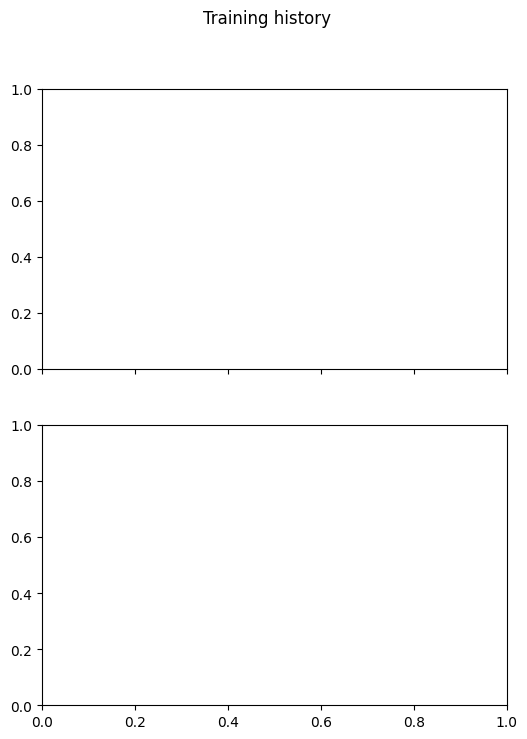

In [ ]:
import matplotlib.pyplot as plt

# Visualizing Training History
fig, axs = plt.subplots(2, figsize=(6, 8), sharex=True)
fig.suptitle('Training history')
x = list(range(1, 21))  # Assuming 20 epochs
axs[0].plot(x, history.history["loss"], alpha=0.5, label="loss")
axs[0].plot(x, history.history["val_loss"], alpha=0.5, label="val_loss")
axs[0].set_ylabel("Loss")
axs[0].legend(loc="upper right")
axs[1].plot(x, history.history["masked_accuracy"], alpha=0.5, label="mask_accuracy")
axs[1].plot(x, history.history["val_masked_accuracy"], alpha=0.5, label="val_mask_accuracy")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].legend(loc="lower right")
plt.show()


#Model Testing
Next, let's define a function to translate English sentences to French using our trained model and evaluate its performance on sample test cases.

In [ ]:
def translate(sentence):
    # Encode input sentence
    enc_tokens = eng_vect([sentence])
    lookup = list(fra_vect.get_vocabulary())
    start_sent, end_sent = "[start]", "[end]"
    output_sent = [start_sent]
    for i in range(seq_length):
        # Prepare decoder input
        vector = fra_vect([" ".join(output_sent)])
        assert vector.shape == (1, seq_length + 1)
        dec_tokens = vector[:, :-1]
        assert dec_tokens.shape == (1, seq_length)
        # Generate predictions
        pred = model([enc_tokens, dec_tokens])
        assert pred.shape == (1, seq_len, vocab_size_fr)
        # Decode predicted token
        word = lookup[np.argmax(pred[0, i, :])]
        output_sent.append(word)
        if word == end_sent:
            break
    return output_sent

# Test the model on sample test cases
test_count = 20
for n in range(test_count):
    eng_sent, fre_sent = random.choice(test_pairs)
    translated = translate(eng_sent)
    print(f"Test case: {n}")
    print(f"English sentence: {eng_sent}")
    print(f"Translated sentence: {' '.join(translated)}")
    print(f"French sentence: {fre_sent}")
    print()
